In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

class PDP(object):
    """
    Creates a partial dependence plotter object for a given target feature.
    
    Parameters
    ----------
    model : A Classifier or a Regressor object.
        Classifer must implement predict_proba() method
             
    feature_name: str
        The name of the target feature for which partial dependence plots are 
        to be created
    
    n_classes: None or int
        The number of class labels for the classifer. 
        Defaults to None, which corresponds to a regression model
    
    training_df : array-like, shape=(n_samples, n_features)
        The data on which `model` was trained.
    
    n_grid : int, default=100
        The number of equally spaced points for target feature `feature_name` 
        for which partial dependence function is to be computed.
        
    percentile : (low, high), default=(0.05, 0.95)
        The lower and upper percentile used to create the extreme value for 
        target feature `feature_name`
    """
    
    def __init__(self, model, feature_name, training_df, n_classes=None, percentile=(0.05, 0.95), n_grid=100):

        self.model = model
        self.n_classes = n_classes 
        self.feature_name = feature_name
        self.training_df = training_df
        self.percentile = percentile
        self.n_grid = n_grid
        
        if self.n_classes is not None and self.n_classes != len(self.model.classes_):
            raise ValueError('The number of classifier labels does not match `n_classes`')
            
        if self.feature_name is None:
            raise ValueError('target variable is not given for PDP')
        
        if self.feature_name not in self.training_df.columns:
            raise ValueError('target variable `%s` is not a feature' % str(self.feature_name))
    
    def calc_partial_dependence(self):
        
        """
        Calculates partial dependence function for the feature `feature_name`. 
        
        Returns
        -------
        pdp : numpy ndarray, shape=(no_of_classes, `n_grid`)
            The partial dependence function evaluated on a grid of `n_grid` 
            equally spaced points of the target feature `feature_name`. The 
            max and min values of the grid are specified through the 
            `percentile` parameter of the object.
            
            For regression ``no_of_classes==1``. For classification, 
            ``no_of_classes == n_classes``
        
        x_vals : numpy ndarray, shape=(`n_grid`, )
            The values of the target feature `feature_name` for which partial 
            dependence function is computed
        """
        
        # Use sklearn's partial dependence algorithm implementation if model is a Gradient Boosted Tree
        
        print("Calculating partial dependence...")
        from sklearn.ensemble.partial_dependence import partial_dependence
        from sklearn.ensemble.gradient_boosting import BaseGradientBoosting
        if isinstance(self.model, BaseGradientBoosting):
            feature_name_idx = list(self.training_df.columns).index(self.feature_name)
            pdp, x_vals = partial_dependence(gbrt=self.model, 
                                            target_variables=feature_name_idx, 
                                            grid=None, 
                                            X=self.training_df, 
                                            percentiles=self.percentile, 
                                            grid_resolution=self.n_grid)
            x_vals = x_vals[0] # Get a grid of x axis values
                                  
            if self.n_classes is None: # Regression
                return pdp, x_vals
            else: 
                # Compute the probabilities for each class. Reference:  Eqns (29) and (30) 
                # in https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451
                odds = np.exp(pdp)
                prob_array = odds/ odds.sum(axis=0)
                return prob_array, x_vals
        
        # Otherwise implement algorithm from scratch
        _df = self.training_df.copy()

        # n_classes is None corresponds to regression
        predict = self.model.predict if self.n_classes is None else self.model.predict_proba
        
        # Get a prediction grid. If feature is non-categorical use equally spaced 
        # points b/w given percentile values. Otherwise use all possible values.
        if self.feature_name in _df.select_dtypes(include=['float64', 'int64']).columns:
            lower_limit = np.percentile(_df[self.feature_name], self.percentile[0]*100)
            upper_limit = np.percentile(_df[self.feature_name], self.percentile[1]*100)
            x_vals = np.linspace(start=lower_limit, stop=upper_limit, num=self.n_grid)
            
        elif self.feature_name in _df.select_dtypes(inlcude=['unit8', 'category', 'bool']).columns:  
            x_vals = _df[self.feature_name].unique()
            
        else:
            raise ValueError('Type of target feature must be one of float64, int64, unit8, category or bool')
         
        pdp = np.asarray([self._get_mean_prediction(_df, predict, val) for val in x_vals]).T
        return pdp, x_vals
    
    def _get_mean_prediction(self, _df, predict, val):
        
        """
        Calculate expected partial dependence prediction for `val`
        """
        
        _df[self.feature_name] = val
        return np.mean(predict(_df), axis=0).tolist()     
    
    def plot_partial_dependence(self, label_name):
        
        """
        Plots partial dependence function for the label `label_name`. 
        
        Parameters
        ----------
        label_name: str
            Name of the label for which partial dependence function is to be 
            plotted. Defaults to None which corresponds to a regressor
        
        Returns
        -------
        fig : figure
            The Matplotlib Figure object.
        ax : Axis object
            An Axis object, for the plot.
        """
        
        if self.n_classes is not None and label_name not in self.model.classes_:
            raise ValueError('label name `%s` not a valid label' % str(label_name))
            
        if self.n_classes is not None and label_name is None:
            raise ValueError('label must be given for a classifer.')
        
        pdp, x_vals = self.calc_partial_dependence()
        
        # Plot one dimensional PDP
        plt.figure(figsize=(12, 8)) # This hardcoded value provides good aspect-ratio
        
        if self.n_classes is not None:
            label_idx = list(self.model.classes_).index(label_name)
            plt.plot(x_vals, pdp[label_idx], lw=1.5)
            fig = plt.gcf()
            return fig, fig.axes[0]
        else:
            plt.plot(x_vals, pdp, lw=1.5)
            fig = plt.gcf()
            return fig, fig.axes[0]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pd_plot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.metrics import confusion_matrix, classification_report

# Create a dataframe with target variable as the median price label, which takes 3 values 'low', 'medium' and 'high'

cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
df['price_cat'] = pd.qcut(cal_housing.target, q=3, labels=['low', 'medium', 'high'])

features = df.drop("price_cat", axis=1)
labels = df["price_cat"]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=labels)

print("Training GBC...")
clf = GradientBoostingClassifier(loss='deviance',
                                 n_estimators=1500, 
                                 max_depth=4,
                                 learning_rate=0.1,
                                 random_state=1)
clf.fit(features_train, labels_train)
print("Done")

print(' GBC:\n {}\n'.format(classification_report(labels_test, clf.predict(features_test))))
confusion_matrix(labels_test, clf.predict(features_test))

Training GBC...


KeyboardInterrupt: 

In [ ]:
print("Training RF...")
rf = RandomForestClassifier(random_state=0)
rf.fit(features_train, labels_train)
print("Done")

print(' RF:\n {}\n'.format(classification_report(labels_test, rf.predict(features_test))))
confusion_matrix(labels_test, rf.predict(features_test))

In [10]:
feature_name ='AveOccup'

label_name='low'

In [ ]:
partial_dependence = PDP(model=rf,
                         #model=clf,
                         n_classes=3,
                         feature_name=feature_name,
                         training_df=features_train,
                         percentile=(0.05, 0.95),
                         n_grid=100)

In [ ]:
fig, ax = partial_dependence.plot_partial_dependence(label_name=label_name)
ax.set_title('Partial dependence plot')
ax.set_ylabel('Prob of belonging to class `{}`'.format(label_name))
ax.set_xlabel(feature_name)

In [ ]:
cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Create a dataframe with target variable as the median price label, which takes 3 values 'low', 'medium' and 'high'

cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
#df['price_cat'] = pd.qcut(cal_housing.target, q=3, labels=['low', 'medium', 'high'])

#features = df.drop("price_cat", axis=1)
features = df
labels = cal_housing.target

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42)

print("Training GBC...")
reg = RandomForestRegressor(n_estimators=1500, 
                                 max_depth=4,
                                 random_state=1)
reg.fit(features_train, labels_train)
print("Done")


Training GBC...
Done


In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
mean_squared_error(reg.predict(features_test), labels_test)

0.5255966576592451

In [11]:
partial_dependence_reg = PDP(model=reg,
    feature_name=feature_name,
    training_df=features_train)

In [ ]:
pdp, xvals = partial_dependence_reg.calc_partial_dependence()

Calculating partial dependence...


Text(0.5,0,'AveOccup')

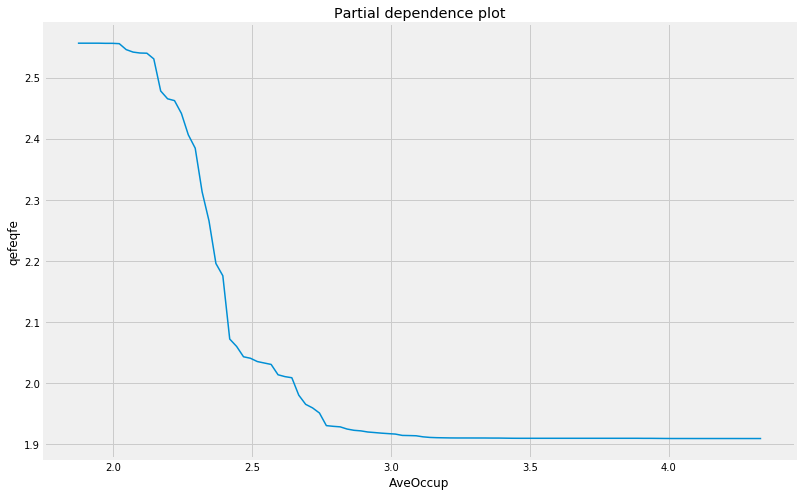

In [13]:
fig, ax = partial_dependence_reg.plot_partial_dependence(label_name='fasfqf')
ax.set_title('Partial dependence plot')
ax.set_ylabel('qefeqfe')
ax.set_xlabel(feature_name)

In [ ]:
xvals.shape